출처 : https://colab.research.google.com/github/teddylee777/machine-learning/blob/master/04-TensorFlow2.0/01-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1/02-LSTM-stock-forecasting-with-LSTM-financedatareader.ipynb#scrollTo=j81HIAlC8K2Q

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

FinanceDataReader는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다. 이를 활용해서 데이터를 불러오겠습니다.

In [2]:
!pip install finance-datareader

You should consider upgrading via the 'c:\users\hyunj\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [4]:
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-02-02,1495,1557,1486,1489,675460,NaN
1998-02-03,1561,1563,1436,1472,666120,-0.011417
1998-02-04,1488,1515,1443,1452,497530,-0.013587
1998-02-05,1416,1446,1336,1336,485790,-0.079890
1998-02-06,1441,1441,1406,1441,1278060,0.078593


Open: 시가
High: 고가
Low: 저가
Close: 종가
Volume: 거래량
Change: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-03-11,70500,70700,69700,70000,15787655,-0.016854
2022-03-14,70000,70200,69600,70200,9040993,0.002857
2022-03-15,69800,70100,69500,69500,10258562,-0.009972
2022-03-16,70200,70500,69700,70400,10175750,0.012950
2022-03-17,71200,71800,70900,71200,17015578,0.011364


In [6]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 1998-02-02 to 2022-03-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


In [7]:
# DatetimeIndex가 있는 것을 확인할 수 있습니다. Date가 index로 돼 있다고 생각하시면 쉽게 이해할 수 있습니다.

samsung.index

DatetimeIndex(['1998-02-02', '1998-02-03', '1998-02-04', '1998-02-05',
               '1998-02-06', '1998-02-07', '1998-02-09', '1998-02-10',
               '1998-02-11', '1998-02-12',
               ...
               '2022-03-03', '2022-03-04', '2022-03-07', '2022-03-08',
               '2022-03-10', '2022-03-11', '2022-03-14', '2022-03-15',
               '2022-03-16', '2022-03-17'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [8]:
samsung.shape

(6000, 6)

DatetimeIndex로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, 월별, 연도별 피벗데이터를 만들때 유용하게 활용할 수 있습니다.

In [9]:
samsung['Year'] = samsung.index.year
samsung['Month'] = samsung.index.month
samsung['Day'] = samsung.index.day

In [10]:
samsung.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-02-02,1495,1557,1486,1489,675460,NaN,1998,2,2
1998-02-03,1561,1563,1436,1472,666120,-0.011417,1998,2,3
1998-02-04,1488,1515,1443,1452,497530,-0.013587,1998,2,4
1998-02-05,1416,1446,1336,1336,485790,-0.079890,1998,2,5
1998-02-06,1441,1441,1406,1441,1278060,0.078593,1998,2,6


시각화 

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


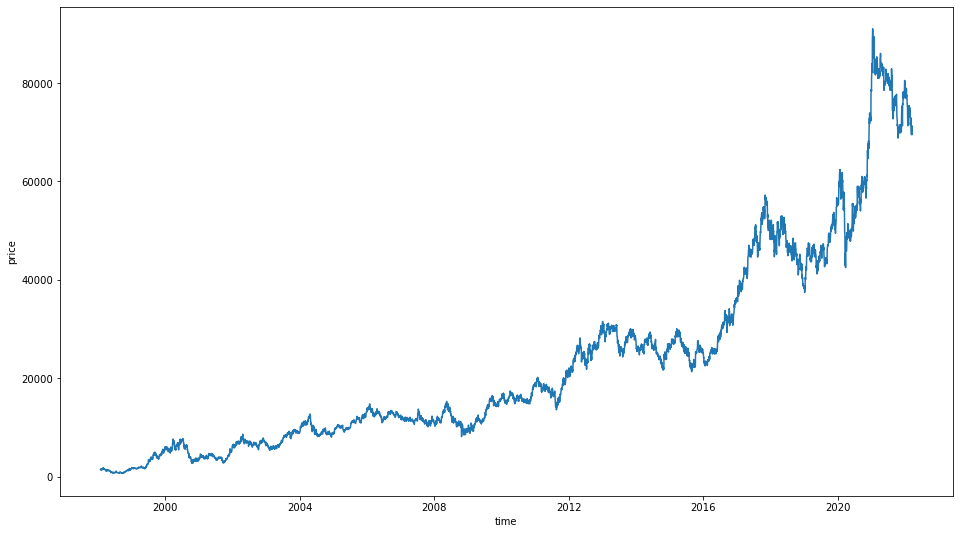

In [11]:
plt.figure(figsize=(16, 9))
# 종가를 확인해야하니
sns.lineplot(y=samsung['Close'], x=samsung.index)
plt.xlabel('time')
plt.ylabel('price')

데이터 전처리

시계열 데이터는 전처리를 위해서 MinMaxScaler를 사용한다고하는데 제가 봤던 예제 코드에서는 y까지 scaling해준 것을 확인하였습니다. 하지만 실장님께서는 y는 해도 되지 않다고 해서 이 데이터 셋에서는 y를 Scaling한 경우와 하지 않은 경우를 구분하여 학습 및 예측해보겠습니다.

y까지 스케일링 한 경우

In [12]:
# 되도록이면 전체 데이터 셋을 scaling 하고 데이터 분할
# 참고: https://nicola-ml.tistory.com/86

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다. (y인 Close까지 정규화 적용)
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
df.head()

,Open,High,Low,Close,Volume
0,0.016556,0.016085,0.016603,0.009418,0.007480
1,0.017287,0.016147,0.016045,0.009230,0.007376
2,0.016478,0.015651,0.016123,0.009008,0.005509
3,0.015681,0.014938,0.014927,0.007724,0.005379
4,0.015958,0.014886,0.015709,0.008886,0.014153


학습을 시킬 데이터셋 생성 => window_sliding

In [13]:
# TEST_SIZE : 며칠을 Test data로 사용할 것인가
TEST_SIZE = 500 # 500일을 사용

train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

데이터 셋을 만들어주는 함수 (window_sliding)

In [14]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [15]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.1)

print(x_train.shape, x_valid.shape)


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
print(test_feature.shape, test_label.shape)

# 즉 4392개를 학습하면서 548개의 데이터에 대해서 검증, 마지막으로 예측은 480개에 대해서!

(4932, 20, 4) (548, 20, 4)
(480, 20, 4) (480, 1)


RNN 모델 생성

In [16]:
# 모델을 만들면서 hiden layer 안의 뉴런의 갯수, hidden layer 개수, epoch, batch_size는 임의로 정했습니다.

from keras.models import Sequential 
from keras.layers import Dense, SimpleRNN 

rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, 
                        input_shape=(train_feature.shape[1], train_feature.shape[2]),
                        return_sequences = True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1)) # The time step of the output 

rnn_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 32)            1184      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 학습
history = rnn_model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    verbose= 1)

Epoch 1/100
309/309 [==============================] - 33s 11ms/step - loss: 0.0086 - val_loss: 0.0010
Epoch 2/100
309/309 [==============================] - 2s 7ms/step - loss: 6.9049e-04 - val_loss: 5.2720e-04
Epoch 3/100
309/309 [==============================] - 2s 8ms/step - loss: 7.3659e-04 - val_loss: 8.7047e-04
Epoch 4/100
309/309 [==============================] - 2s 7ms/step - loss: 4.6884e-04 - val_loss: 6.4661e-04
Epoch 5/100
309/309 [==============================] - 2s 8ms/step - loss: 2.5306e-04 - val_loss: 7.2883e-04
Epoch 6/100
309/309 [==============================] - 2s 7ms/step - loss: 1.4655e-04 - val_loss: 7.7193e-04
Epoch 7/100
309/309 [==============================] - 2s 8ms/step - loss: 2.1655e-04 - val_loss: 8.0856e-04
Epoch 8/100
309/309 [==============================] - 2s 8ms/step - loss: 2.6444e-04 - val_loss: 7.7176e-04
Epoch 9/100
309/309 [==============================] - 3s 8ms/step - loss: 2.0901e-04 - val_loss: 7.3390e-04
Epoch 10/100
309/309 [===

309/309 [==============================] - 2s 8ms/step - loss: 2.7097e-04 - val_loss: 6.8599e-04
Epoch 76/100
309/309 [==============================] - 3s 8ms/step - loss: 1.4005e-04 - val_loss: 6.9182e-04
Epoch 77/100
309/309 [==============================] - 3s 9ms/step - loss: 1.8439e-04 - val_loss: 5.3400e-04
Epoch 78/100
309/309 [==============================] - 2s 8ms/step - loss: 7.0331e-05 - val_loss: 4.9164e-04
Epoch 79/100
309/309 [==============================] - 2s 7ms/step - loss: 1.8125e-04 - val_loss: 5.5402e-04
Epoch 80/100
309/309 [==============================] - 2s 8ms/step - loss: 8.3666e-05 - val_loss: 7.1713e-04
Epoch 81/100
309/309 [==============================] - 2s 8ms/step - loss: 1.4196e-04 - val_loss: 4.9167e-04
Epoch 82/100
309/309 [==============================] - 2s 7ms/step - loss: 1.1686e-04 - val_loss: 6.4080e-04
Epoch 83/100
309/309 [==============================] - 2s 8ms/step - loss: 1.3981e-04 - val_loss: 5.4339e-04
Epoch 84/100
309/309 [=

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


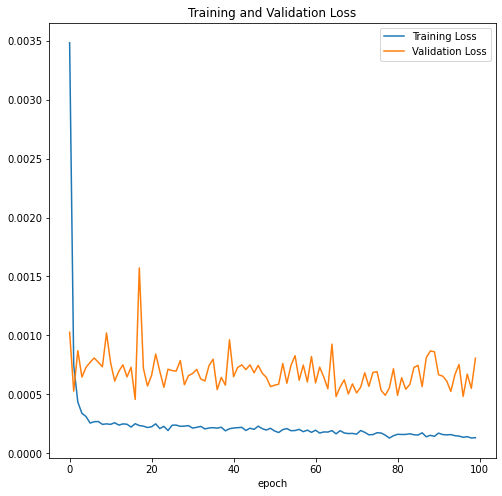

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.figure(figsize=(8, 8)) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.xlabel('epoch') 
plt.show()

In [19]:
# 예측
pred = rnn_model.predict(test_feature)

실제 데이터와 예측한 데이터 시각화

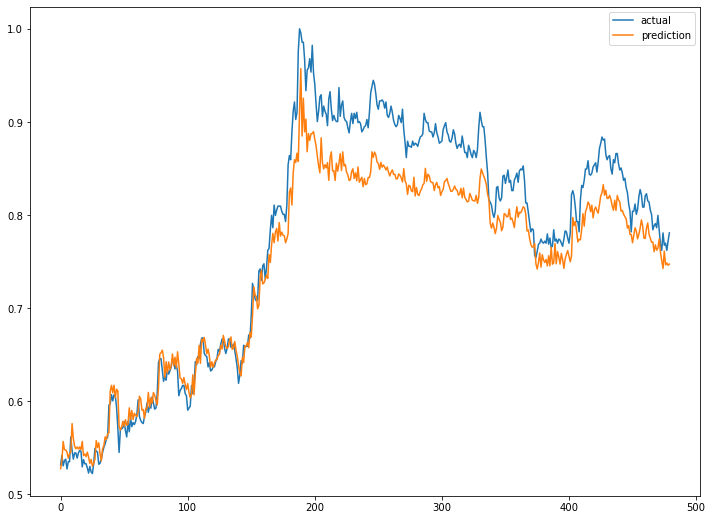

In [20]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [21]:
# Mape 정의
# MAPE는 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있음
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape 
    
# RMSE는 MSE에 ROOT값을 씌운 것
# RMSE 정의
from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [22]:
print('y를 Scaling한 RNN 모델의 MAPE : ', MAPE(test_label, pred))
print('y를 Scaling한 RNN 모델의 RMSE : ', RMSE(test_label, pred)) 

y를 Scaling한 RNN 모델의 MAPE :  3.9071609747690887
y를 Scaling한 RNN 모델의 RMSE :  0.03998722003769663


LSTM 모델 생성

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=True)
          )
lstm_model.add(LSTM(32, 
               activation='relu', 
               return_sequences=False)
          )
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 학습
history = lstm_model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    verbose= 1)

Epoch 1/100
309/309 [==============================] - 12s 17ms/step - loss: 0.0139 - val_loss: 1.3373e-04
Epoch 2/100
309/309 [==============================] - 4s 13ms/step - loss: 1.2782e-04 - val_loss: 9.1380e-05
Epoch 3/100
309/309 [==============================] - 4s 13ms/step - loss: 1.1493e-04 - val_loss: 1.0600e-04
Epoch 4/100
309/309 [==============================] - 4s 13ms/step - loss: 1.2155e-04 - val_loss: 7.9084e-05
Epoch 5/100
309/309 [==============================] - 4s 13ms/step - loss: 1.0355e-04 - val_loss: 2.6695e-04
Epoch 6/100
309/309 [==============================] - 5s 17ms/step - loss: 1.3378e-04 - val_loss: 8.5017e-05
Epoch 7/100
309/309 [==============================] - 4s 13ms/step - loss: 1.0445e-04 - val_loss: 1.0948e-04
Epoch 8/100
309/309 [==============================] - 4s 13ms/step - loss: 9.6842e-05 - val_loss: 1.4677e-04
Epoch 9/100
309/309 [==============================] - 5s 15ms/step - loss: 1.0756e-04 - val_loss: 6.6330e-05
Epoch 10/100


309/309 [==============================] - 4s 14ms/step - loss: 2.7338e-05 - val_loss: 2.9748e-05
Epoch 75/100
309/309 [==============================] - 5s 15ms/step - loss: 3.1129e-05 - val_loss: 3.0300e-05
Epoch 76/100
309/309 [==============================] - 5s 17ms/step - loss: 2.8696e-05 - val_loss: 3.5293e-05
Epoch 77/100
309/309 [==============================] - 4s 13ms/step - loss: 2.8812e-05 - val_loss: 3.6359e-05 2s - lo
Epoch 78/100
309/309 [==============================] - 4s 14ms/step - loss: 2.9773e-05 - val_loss: 2.6333e-05
Epoch 79/100
309/309 [==============================] - 5s 17ms/step - loss: 3.2559e-05 - val_loss: 4.3161e-05
Epoch 80/100
309/309 [==============================] - 6s 18ms/step - loss: 3.0074e-05 - val_loss: 6.6765e-05
Epoch 81/100
309/309 [==============================] - 4s 14ms/step - loss: 2.8491e-05 - val_loss: 2.3470e-05
Epoch 82/100
309/309 [==============================] - 4s 14ms/step - loss: 2.7243e-05 - val_loss: 4.3613e-05
Epoch 

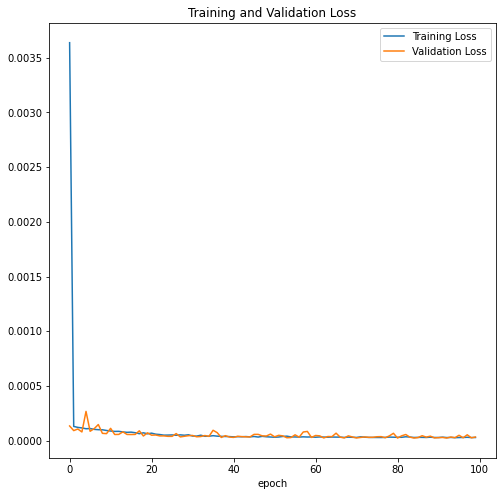

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.figure(figsize=(8, 8)) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.xlabel('epoch') 
plt.show()

In [26]:
# 예측
pred = lstm_model.predict(test_feature)

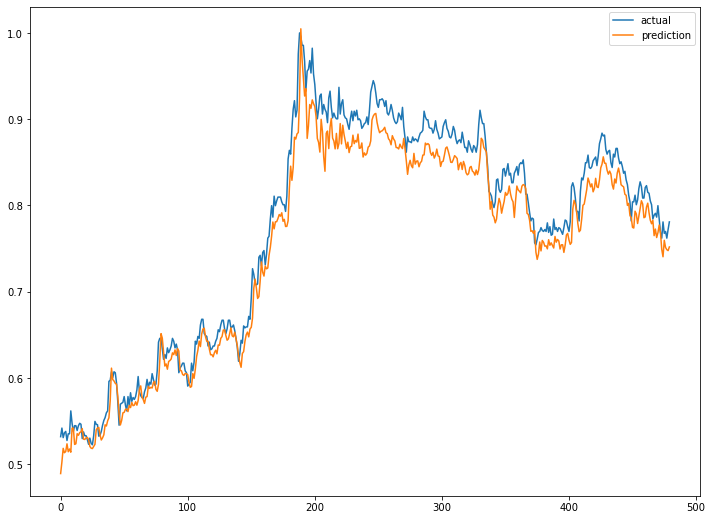

In [27]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [28]:
print('y를 Scaling한 LSTM 모델의 MAPE : ', MAPE(test_label, pred))
print('y를 Scaling한 LSTM 모델의 RMSE : ', RMSE(test_label, pred)) 

y를 Scaling한 LSTM 모델의 MAPE :  2.7917945070252412
y를 Scaling한 LSTM 모델의 RMSE :  0.02676055203076585


y를 scaling 하지않은 전처리

In [29]:
# 데이터 다시 호출

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [30]:
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-02-02,1495,1557,1486,1489,675460,NaN
1998-02-03,1561,1563,1436,1472,666120,-0.011417
1998-02-04,1488,1515,1443,1452,497530,-0.013587
1998-02-05,1416,1446,1336,1336,485790,-0.079890
1998-02-06,1441,1441,1406,1441,1278060,0.078593


In [31]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다. (y인 Close까지 정규화 적용)
scale_cols = ['Open', 'High', 'Low', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
df.head()

,Open,High,Low,Volume
0,0.016556,0.016085,0.016603,0.007480
1,0.017287,0.016147,0.016045,0.007376
2,0.016478,0.015651,0.016123,0.005509
3,0.015681,0.014938,0.014927,0.005379
4,0.015958,0.014886,0.015709,0.014153


In [32]:
df_y = pd.DataFrame(samsung['Close'])
df_y.head()

,Close
Date,
1998-02-02,1489
1998-02-03,1472
1998-02-04,1452
1998-02-05,1336
1998-02-06,1441


In [33]:
# TEST_SIZE : 며칠을 Test data로 사용할 것인가
TEST_SIZE = 500 # 500일을 사용

train_x = df[:-TEST_SIZE]
test_x = df[-TEST_SIZE:]
train_y = df_y[:-TEST_SIZE]
test_y = df_y[-TEST_SIZE:]

In [34]:
train_x

,Open,High,Low,Volume
0,0.016556,0.016085,0.016603,0.007480
1,0.017287,0.016147,0.016045,0.007376
2,0.016478,0.015651,0.016123,0.005509
3,0.015681,0.014938,0.014927,0.005379
4,0.015958,0.014886,0.015709,0.014153
...,...,...,...,...
5495,0.601329,0.573347,0.598883,0.336670
5496,0.627907,0.587810,0.615642,0.335861
5497,0.606866,0.595041,0.610056,0.274242
5498,0.637874,0.599174,0.633520,0.240282


In [35]:
test_x

,Open,High,Low,Volume
5500,0.605759,0.568182,0.598883,0.335099
5501,0.595792,0.567149,0.600000,0.355530
5502,0.601329,0.561983,0.581006,0.506137
5503,0.564784,0.536157,0.550838,0.533186
5504,0.525471,0.533058,0.523464,0.658459
...,...,...,...,...
5995,0.780731,0.730372,0.778771,0.174824
5996,0.775194,0.725207,0.777654,0.100115
5997,0.772979,0.724174,0.776536,0.113598
5998,0.777409,0.728306,0.778771,0.112681


In [36]:
train_y

,Close
Date,
1998-02-02,1489
1998-02-03,1472
1998-02-04,1452
1998-02-05,1336
1998-02-06,1441
...,...
2020-03-02,55000
2020-03-03,55400
2020-03-04,57400


In [37]:
test_y

,Close
Date,
2020-03-09,54200
2020-03-10,54600
2020-03-11,52100
2020-03-12,50800
2020-03-13,49950
...,...
2022-03-11,70000
2022-03-14,70200
2022-03-15,69500


In [38]:
# train dataset
train_feature, train_label = make_dataset(train_x, train_y, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.1)

print(x_train.shape, x_valid.shape)


test_feature, test_label = make_dataset(test_x, test_y, 20)
print(test_feature.shape, test_label.shape)

# 즉 4392개를 학습하면서 548개의 데이터에 대해서 검증, 마지막으로 예측은 480개에 대해서!

(4932, 20, 4) (548, 20, 4)
(480, 20, 4) (480, 1)


똑같은 RNN 모델 생성 

In [39]:
# 모델을 만들면서 hiden layer 안의 뉴런의 갯수, hidden layer 개수, epoch, batch_size는 임의로 정했습니다.

from keras.models import Sequential 
from keras.layers import Dense, SimpleRNN 

rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, 
                        input_shape=(train_feature.shape[1], train_feature.shape[2]),
                        return_sequences = True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1)) # The time step of the output 

rnn_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 20, 32)            1184      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [40]:
# 학습
history = rnn_model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    verbose= 1)

Epoch 1/100
309/309 [==============================] - 6s 10ms/step - loss: 575130148.7484 - val_loss: 539022144.0000
Epoch 2/100
309/309 [==============================] - 2s 8ms/step - loss: 554675523.9226 - val_loss: 538656256.0000
Epoch 3/100
309/309 [==============================] - 3s 9ms/step - loss: 547666637.2129 - val_loss: 538291008.0000
Epoch 4/100
309/309 [==============================] - 3s 8ms/step - loss: 552158502.1935 - val_loss: 537926080.0000
Epoch 5/100
309/309 [==============================] - 3s 8ms/step - loss: 560671828.4387 - val_loss: 537561344.0000
Epoch 6/100
309/309 [==============================] - 3s 9ms/step - loss: 543745634.3742 - val_loss: 537196544.0000
Epoch 7/100
309/309 [==============================] - 3s 8ms/step - loss: 553818583.9484 - val_loss: 536832832.0000
Epoch 8/100
309/309 [==============================] - 2s 8ms/step - loss: 558229140.3355 - val_loss: 536466944.0000
Epoch 9/100
309/309 [==============================] - 3s 9ms/s

309/309 [==============================] - 2s 7ms/step - loss: 550803079.7419 - val_loss: 514276352.0000
Epoch 71/100
309/309 [==============================] - 2s 7ms/step - loss: 520803123.0968 - val_loss: 513923392.0000
Epoch 72/100
309/309 [==============================] - 2s 7ms/step - loss: 534718539.6645 - val_loss: 513572448.0000
Epoch 73/100
309/309 [==============================] - 2s 7ms/step - loss: 530656547.9226 - val_loss: 513220000.0000
Epoch 74/100
309/309 [==============================] - 2s 8ms/step - loss: 541537733.4710 - val_loss: 512870400.0000
Epoch 75/100
309/309 [==============================] - 3s 10ms/step - loss: 529417586.8903 - val_loss: 512520704.0000
Epoch 76/100
309/309 [==============================] - 2s 8ms/step - loss: 521065517.0581 - val_loss: 512171328.0000
Epoch 77/100
309/309 [==============================] - 2s 7ms/step - loss: 522792972.0774 - val_loss: 511821024.0000
Epoch 78/100
309/309 [==============================] - 2s 7ms/step 

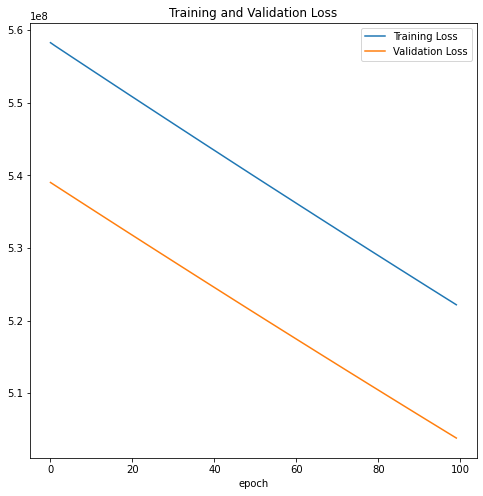

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.figure(figsize=(8, 8)) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.xlabel('epoch') 
plt.show()

In [42]:
# 예측
pred = rnn_model.predict(test_feature)

실제 데이터와 예측한 데이터의 시각화

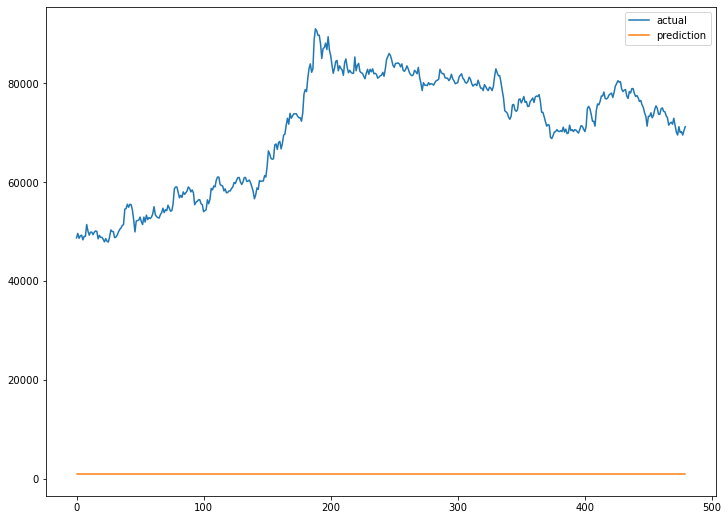

In [43]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [44]:
print('y를 Scaling하지 않은 RNN 모델의 MAPE : ', MAPE(test_label, pred))
print('y를 Scaling하지 않은 RNN 모델의 RMSE : ', RMSE(test_label, pred)) 

y를 Scaling하지 않은 RNN 모델의 MAPE :  98.52732906897766
y를 Scaling하지 않은 RNN 모델의 RMSE :  70459.4801411003


똑같은 LSTM 모델 생성

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=True)
          )
lstm_model.add(LSTM(32, 
               activation='relu', 
               return_sequences=False)
          )
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 32)            4736      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [46]:
# 학습
history = lstm_model.fit(x_train, y_train, 
                    epochs=100, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    verbose= 1)

Epoch 1/100
309/309 [==============================] - 9s 19ms/step - loss: 299015624.6452 - val_loss: 6647071.5000
Epoch 2/100
309/309 [==============================] - 4s 13ms/step - loss: 4271088.4726 - val_loss: 3361584.2500
Epoch 3/100
309/309 [==============================] - 4s 13ms/step - loss: 4395572.3065 - val_loss: 3277155.7500
Epoch 4/100
309/309 [==============================] - 4s 13ms/step - loss: 3302544.9573 - val_loss: 3292474.0000
Epoch 5/100
309/309 [==============================] - 5s 16ms/step - loss: 3597202.2565 - val_loss: 4102321.0000
Epoch 6/100
309/309 [==============================] - 4s 13ms/step - loss: 3190694.1706 - val_loss: 3580783.2500
Epoch 7/100
309/309 [==============================] - 4s 13ms/step - loss: 2812700.5113 - val_loss: 3144801.7500
Epoch 8/100
309/309 [==============================] - 4s 13ms/step - loss: 3680989.0734 - val_loss: 2722485.7500
Epoch 9/100
309/309 [==============================] - 4s 13ms/step - loss: 3967695.29

309/309 [==============================] - 4s 13ms/step - loss: 2100480.4395 - val_loss: 1543410.0000
Epoch 73/100
309/309 [==============================] - 4s 13ms/step - loss: 2146825.6300 - val_loss: 5338331.0000
Epoch 74/100
309/309 [==============================] - 4s 13ms/step - loss: 2647490.9927 - val_loss: 1882637.3750
Epoch 75/100
309/309 [==============================] - 4s 13ms/step - loss: 2336507.7351 - val_loss: 2564905.0000
Epoch 76/100
309/309 [==============================] - 4s 13ms/step - loss: 2227749.4181 - val_loss: 1452881.2500
Epoch 77/100
309/309 [==============================] - 4s 13ms/step - loss: 2144113.9815 - val_loss: 1497722.1250
Epoch 78/100
309/309 [==============================] - 4s 13ms/step - loss: 2048204.0363 - val_loss: 1573585.2500
Epoch 79/100
309/309 [==============================] - 4s 14ms/step - loss: 2173770.6129 - val_loss: 1498678.0000
Epoch 80/100
309/309 [==============================] - 4s 13ms/step - loss: 2272134.5935 - v

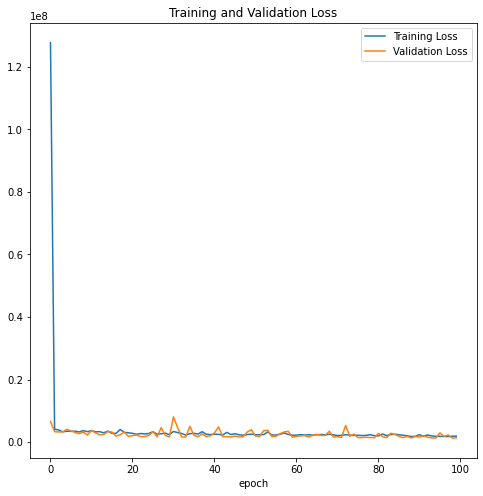

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss'] 
plt.figure(figsize=(8, 8)) 
plt.plot(loss, label='Training Loss') 
plt.plot(val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.xlabel('epoch') 
plt.show()

In [48]:
# 예측
pred = lstm_model.predict(test_feature)

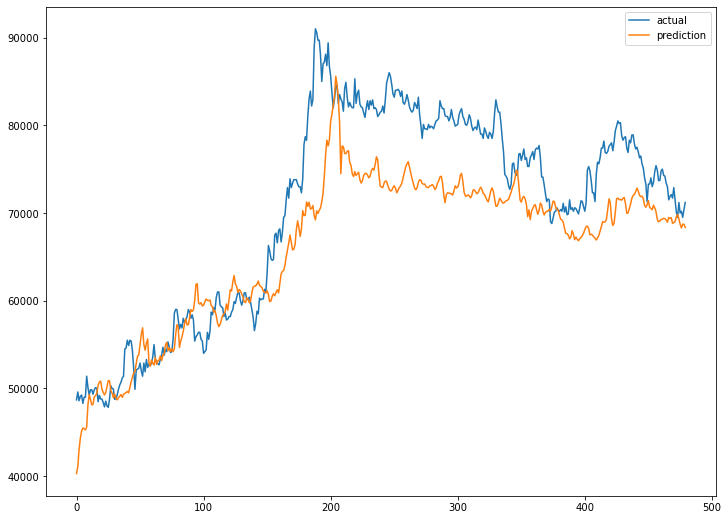

In [49]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [50]:
print('y를 Scaling하지 않은 LSTM 모델의 MAPE : ', MAPE(test_label, pred))
print('y를 Scaling하지 않은 LSTM 모델의 RMSE : ', RMSE(test_label, pred)) 

y를 Scaling하지 않은 LSTM 모델의 MAPE :  6.753616454499743
y를 Scaling하지 않은 LSTM 모델의 RMSE :  6249.378272518231


정리(비교를 위해서 두 경우 모두 같은 모델을 사용하였지만, 모델의 튜닝을 데이터의 형태에 따라 적절하게 사용하면 당연히 예측 성능은 더 올라갈 수 있다.)

* y를 Scaling한 RNN : Val_loss의 값이 튀(?)는 것을 확인할 수 있다. 과적합의 영향이 있어보이지만 후의 LSTM의 MAPE, RMSE와 비교하면 RNN이 장기예측에 부적합하다는 것을 확인할 수 있다.

* y를 Scaling한 LSTM : TEST 데이터의 시각화와 RMSE, MAPE 수치가 아주 좋은 것을 보여준다. 또, Val_loss 그래프를 꾸준히 감소하지만 예측값과 실제값이 너무 비슷해서 아무래도 과적합이 일어난 것으로 추측한다.

* y를 Scaling하지 않은 RNN : 학습이 전혀 안되는 것을 확인할 수 있다. 학습이 안된 이유는 RNN의 파라미터 개수는 약 3000개이다. y를 scaling하지 않았을 때는 y를 scaling할 때보다 수치가 매우 큰 것을 확인할 수 있다. 이 모델의 파라미터의 개수로는 상대적으로 수치가 큰 타겟에 대해서 학습을 못하는 것을 확인할 수 있다. 그래도 val_loss와 loss그래프를 확인하면 수치가 계속 낮아지는 것을 확인할 수 있다. 즉, 파라미터의 개수를 늘린다(LAYER를 늘리거나 각 LAYER의 NODE를 증가시켜서)면 적절하게 학습할 수 있음을 유추할 수 있다. 

* y를 Scaling하지 않은 LSTM : RNN과 다르게 학습이 어느정도 되는 것을 확인할 수 있다. LSTM의 파라미터 개수는 약 13000개 정도인데 파라미터의 개수가 더 많기 때문에 학습이 어느정도 되는 것이다. 